In [1]:
import numpy as np
import matplotlib as plt
import xarray as xr

In [12]:
#Load in observations and model data
models=xr.open_dataset("/g/data/eg3/jp0715/HydroProj/data/hydroproj/gcm/spatial/nrms/annual/ensemble_members_combined/tasmin_historical_1976-2005_AU_spatial_ensemble_members.nc")
obs=xr.open_dataset("/g/data/eg3/jp0715/HydroProj/data/hydroproj/awap/spatial/nrms/annual/tasmin_AWAP_1976-2005_AU_spatial_stats.nc")
#Rerrange index of observation latitudes so it matches model data (necessary?)
obs_adjusted=obs.reindex(lat=list(reversed(obs.lat)))
#Subdivide model dataset into bias corrected and gdd data
models_bc=models.sel(bc_method=["isimip","mrnbc","qme"])
models_gdd=models.sel(bc_method="nobc")
#Create empty datasets for added value calculations
Added_Value=xr.Dataset()
avs_initial=xr.Dataset()
#Convert datasets to data-arrays so variables can be extracted (better way?)
new_models_gdd=models_gdd.to_array()
new_models_bc=models_bc.to_array()
new_obs=obs_adjusted.to_array()

#Obtain arrays of the bias corrections, models and variables coordinates
coords_bc=new_models_bc.coords["bc_method"].values
coords_model=new_models_bc.coords["model"].values
variables=new_models_bc.coords["variable"].values

#Obtain number of bias corrections, models and variables to iterate over
bc_number=len(coords_bc)
model_number=len(coords_model)
variable_number=len(variables)

#Iterate the AV formula over every model, bc_method and variable
for h in range(variable_number):
    for i in range(model_number):
        for j in range(bc_number):
            av_lhs=np.abs(new_models_gdd.isel(variable=h,model=i)-new_obs.isel(variable=h))
            av_rhs=np.abs(new_models_bc.isel(variable=h,model=i,bc_method=j)-new_obs.isel(variable=h))
            av=av_lhs-av_rhs
            avs_initial[str(coords_model[i])+"_"+str(coords_bc[j])]=av
    
    #Create new dataset that with a similar structure to initial dataset
    avs_transition=avs_initial.to_array()
    avs_transition=avs_transition.reset_coords(drop="true") #Height and Model remain as dimensionless coordinates, so remove them
    ds=avs_transition.to_dataset(name=variables[h])
    #Every combination of bc_method and model is across one dimension. Divide into two dimensions of bc_method and model
    multiindex_ds=ds.assign_coords(
        model=coords_model,bc_method=coords_bc
    ).stack(
        dim=("model","bc_method")
    ).reset_index(
        "variable", drop=True
    ).rename(
        variable="dim"
    )
    Nearly_There=multiindex_ds.unstack("dim")
    #Save current variable iteration in the Added Value dataset
    Added_Value[variables[h]]=Nearly_There[variables[h]]
Added_Value

<xarray.Dataset>
Dimensions:           (lat: 681, lon: 841, model: 4, bc_method: 3)
Coordinates:
  * lat               (lat) float64 -44.0 -43.95 -43.9 ... -10.1 -10.05 -10.0
  * lon               (lon) float64 112.0 112.0 112.1 ... 153.9 153.9 154.0
  * model             (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-G...
  * bc_method         (bc_method) object 'isimip' 'mrnbc' 'qme'
Data variables: (12/21)
    tasmin_q_0.00027  (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_q_0.00055  (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_q_0.00137  (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_q_0.00274  (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_q_0.01     (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_q_0.05     (lat, lon, model, bc_method) float64 nan nan ... nan nan
    ...                ...
    tasmin_q_0.99945  (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_q_0.99973  (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_mean       (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_std        (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_max        (lat, lon, model, bc_method) float64 nan nan ... nan nan
    tasmin_min        (lat, lon, model, bc_method) float64 nan nan ... nan nan

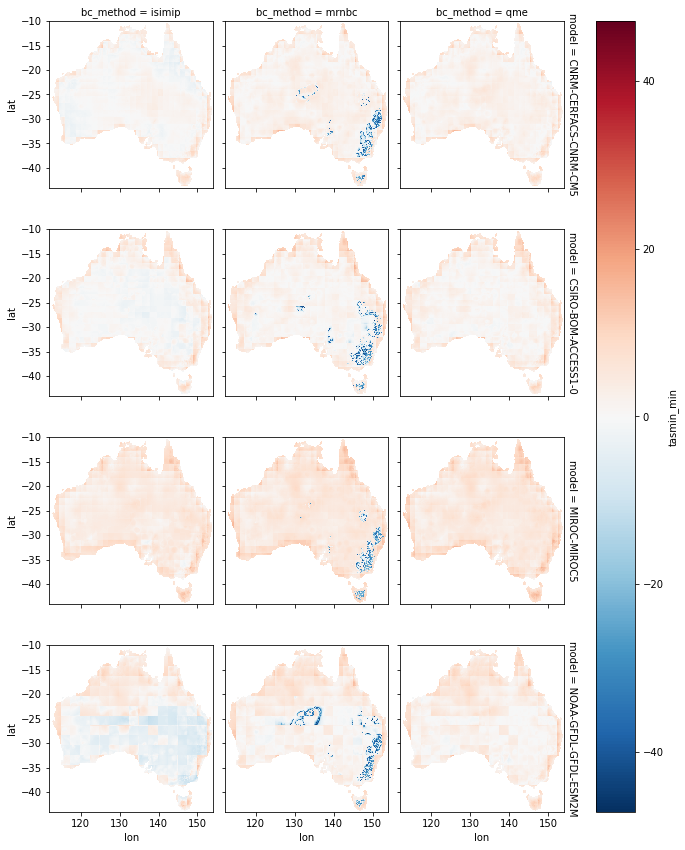

In [13]:
Added_Value["tasmin_min"].plot(row="model",col="bc_method")

In [23]:
#Percentage of gridsquares which have a positive AV for tasmin_min
Added_Value["tasmin_min"].where(Added_Value["tasmin_min"]>0).count(dim=["lat","lon"])/Added_Value["tasmin_min"].count(dim=["lat","lon"])*100

<xarray.DataArray 'tasmin_min' (models: 4, bc: 3)>
array([[66.03717314, 91.96321741, 93.78565976],
       [58.86634358, 83.9310504 , 86.20226873],
       [99.20115034, 96.51275497, 99.89490689],
       [48.15572243, 81.54444267, 89.76904369]])
Coordinates:
    height   float64 2.0
    model    <U21 'CNRM-CERFACS-CNRM-CM5'
  * models   (models) object 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-GFDL-ESM2M'
  * bc       (bc) object 'isimip' 'mrnbc' 'qme'

In [4]:
Added_Value["tasmin_min"].mean(dim=["lat","lon"])

<xarray.DataArray 'tasmin_min' (model: 4, bc_method: 3)>
array([[ 0.82657126,  1.57835684,  2.29544162],
       [ 1.04381389,  1.21544388,  2.11632918],
       [ 4.69026275,  4.71690642,  5.52332927],
       [-0.14112792,  1.50434289,  2.92466862]])
Coordinates:
  * model      (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-GFDL-ESM2M'
  * bc_method  (bc_method) object 'isimip' 'mrnbc' 'qme'

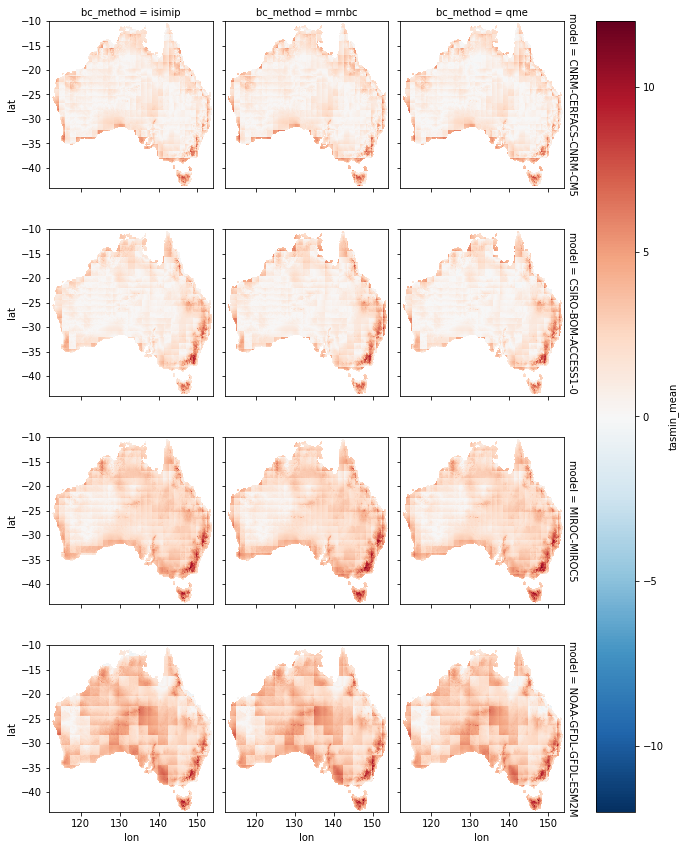

In [4]:
Added_Value["tasmin_mean"].plot(row="model",col="bc_method")

In [9]:
#Percentage of gridsquares which have a positive AV for tasmin_mean
Added_Value["tasmin_mean"].where(Added_Value["tasmin_mean"]>0).count(dim=["lat","lon"])/Added_Value["tasmin_mean"].count(dim=["lat","lon"])*100

<xarray.DataArray 'tasmin_mean' (model: 4, bc_method: 3)>
array([[99.66235288, 99.94283787, 95.04642204],
       [99.75537448, 99.94354796, 94.39101028],
       [99.89135645, 99.99467434, 99.23132911],
       [99.67264916, 99.99396425, 98.28336085]])
Coordinates:
  * model      (model) object 'CNRM-CERFACS-CNRM-CM5' ... 'NOAA-GFDL-GFDL-ESM2M'
  * bc_method  (bc_method) object 'isimip' 'mrnbc' 'qme'